## Overview: Payroll Based Daily Nurse and Non_Nurse Staffinig In US Nursing Homes
- Payroll Based Journal (PBJ) Daily Nurse and Non_Nurse Staffinig are data about nursing home staffing based on data submitted by nursing homes to CMS through the Payroll Based Journal (PBJ) system and daily resident census information based on Minimum Data Set (MDS) records. The data are open to pubic and can be found on this website: https://data.cms.gov/browse?q=PBJ&sortBy=newest.    
- The staffing data are aggregated to the facility-day. All included facilities have one record for each day in the quarter. This results in 90-92 records records per facility for each quarter. The total number of records in the file will be equal to the number of included facilities multiplied by the number of calendar days in the quarter.

### Data: 2020 Q4 PBJ Daily Nurse Staffing






In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
from utils import check_null_values, staff_hours_per_person

In [54]:
q4_holidays = ['2020-11-23','2020-11-24','2020-11-25','2020-11-26', '2020-11-27', '2020-12-21',
            '2020-12-22', '2020-12-23','2020-12-24', '2020-12-25', '2020-12-31']

# There are totally 128 unique provider numbers from Ensign
provider_df = pd.read_csv('Our_Provider_numbers.csv')
provider_df.head()

prov_nums = provider_df['our_provnum']
ensign_prov_nums = prov_nums.squeeze().squeeze().tolist()

### Drop
(1) Total nurse staffing <1.5 hours per resident per day; or  
(2) Total nurse staffing > 12 hours per resident per day; or  
(3) Nurse aide staffing > 5.25 hours per resident per day  
(4) MDScensus = 0  

In [55]:
def drop_by_hours_per_person(df):
    df = df[df['total_hours'] > 1.5]
    df = df[df['total_hours'] < 12.0]
    df = df[df['Hrs_NAtrn'] < 5.25]
    df = df[df['MDScensus'] > 0]
    
    return df

In [4]:
def add_features(origin_df, holidays, prov_nums):
    df = origin_df.copy()
    df = df[df['MDScensus'] > 0]
    df['WorkDate'] = pd.to_datetime(df.WorkDate, format="%Y%m%d")
    df['year'] = df['WorkDate'].dt.year
    df['month'] = df['WorkDate'].dt.month
    df['day'] = df['WorkDate'].dt.day
    df['day_name'] = df['WorkDate'].dt.day_name()
    df['is_weekend'] = (df['WorkDate'].dt.dayofweek // 5 == 1).astype(bool)
    df['is_holiday_week'] = df['WorkDate'].dt.date.astype('datetime64').isin(holidays)
    df['IsEnsign'] = df['PROVNUM'].isin(prov_nums)
    df['total_hours'] = df['Hrs_RNDON'] + df['Hrs_RNadmin'] + df['Hrs_RN'] + df['Hrs_LPNadmin'] + df['Hrs_LPN'] + df['Hrs_CNA'] + df['Hrs_NAtrn'] + df['Hrs_MedAide']
    df['total_admin_hours'] = df['Hrs_RNDON'] + df['Hrs_RNadmin'] + df['Hrs_LPNadmin']
    df['total_non_admin'] = df['Hrs_RN'] + df['Hrs_LPN'] + df['Hrs_CNA'] + df['Hrs_NAtrn'] + df['Hrs_MedAide']
    df['total_ctr_hours'] = df['Hrs_RN_ctr'] + df['Hrs_LPNadmin_ctr'] + df['Hrs_LPN_ctr'] + df['Hrs_CNA_ctr'] + df['Hrs_NAtrn_ctr'] + df['Hrs_MedAide_ctr']
    df['total_non_ctr'] = df['total_hours'] - df['total_ctr_hours']
#     df.drop(df.iloc[:, 9:33], inplace = True, axis = 1)
    return df

In [5]:
hour_features = ['total_hours', 'total_admin_hours', 'total_non_admin', 'total_ctr_hours', 'total_non_ctr','Hrs_RNDON', 'Hrs_RNDON_emp',
       'Hrs_RNDON_ctr', 'Hrs_RNadmin', 'Hrs_RNadmin_emp', 'Hrs_RNadmin_ctr', 'Hrs_RN', 'Hrs_RN_emp', 'Hrs_RN_ctr', 'Hrs_LPNadmin',
       'Hrs_LPNadmin_emp', 'Hrs_LPNadmin_ctr', 'Hrs_LPN', 'Hrs_LPN_emp', 'Hrs_LPN_ctr', 'Hrs_CNA', 'Hrs_CNA_emp', 'Hrs_CNA_ctr', 'Hrs_NAtrn',
       'Hrs_NAtrn_emp', 'Hrs_NAtrn_ctr', 'Hrs_MedAide', 'Hrs_MedAide_emp','Hrs_MedAide_ctr']
features = ['total_hours', 'total_admin_hours', 'total_non_admin', 'total_ctr_hours', 'total_non_ctr', 'Hrs_NAtrn']

In [56]:
nursing_df = pd.read_csv('PBJ_Daily_Nurse_Staffing_CY_2020Q4.csv')
nursing_df.head()

c:\users\hua13\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,PROVNUM,PROVNAME,CITY,STATE,COUNTY_NAME,COUNTY_FIPS,CY_Qtr,WorkDate,MDScensus,Hrs_RNDON,...,Hrs_LPN_ctr,Hrs_CNA,Hrs_CNA_emp,Hrs_CNA_ctr,Hrs_NAtrn,Hrs_NAtrn_emp,Hrs_NAtrn_ctr,Hrs_MedAide,Hrs_MedAide_emp,Hrs_MedAide_ctr
0,15009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2020Q4,20201001,52,0.00,...,0.0,145.73,138.23,7.50,7.75,7.75,0.0,0.0,0.0,0.0
1,15009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2020Q4,20201002,52,7.00,...,0.0,146.21,138.46,7.75,0.00,0.00,0.0,0.0,0.0,0.0
2,15009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2020Q4,20201003,52,0.00,...,0.0,140.66,140.66,0.00,0.00,0.00,0.0,0.0,0.0,0.0
3,15009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2020Q4,20201004,51,0.00,...,0.0,115.95,108.45,7.50,0.00,0.00,0.0,0.0,0.0,0.0
4,15009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,Franklin,59,2020Q4,20201005,51,8.25,...,0.0,154.85,143.10,11.75,7.75,7.75,0.0,0.0,0.0,0.0


In [147]:
ensign_nurse_df = all_nursing_df[all_nursing_df["IsEnsign"] == True]
ensign_nurse_df[features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,Hrs_NAtrn
count,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000
mean,279.750360,22.169409,257.580951,2.813189,276.937171,10.060573
std,119.988771,16.368282,114.839496,9.496873,119.397655,16.495480
min,56.640000,0.000000,56.640000,0.000000,56.640000,0.000000
25%,198.972500,8.000000,181.767500,0.000000,196.777500,0.000000
50%,262.885000,24.000000,239.495000,0.000000,260.260000,0.000000
75%,331.882500,32.070000,303.210000,0.000000,328.790000,15.250000
max,918.600000,89.500000,864.320000,110.170000,918.600000,134.270000


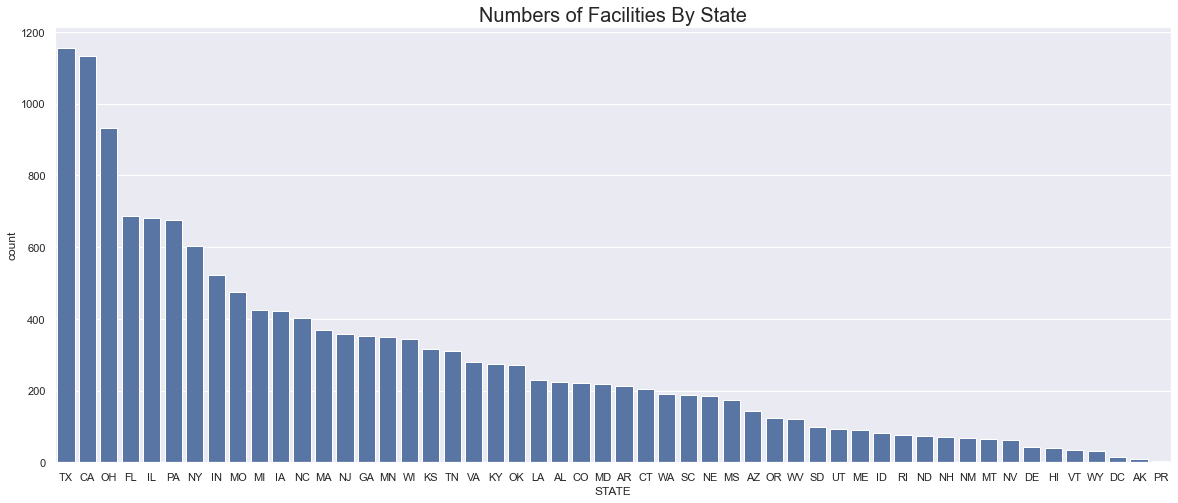

In [146]:
sns.set(rc={"figure.figsize":(20, 8)})
nursing_facilities_df = nursing_df.groupby('PROVNUM').first()
ax = sns.countplot(x="STATE", data=nursing_facilities_df, color='b',
                   order = nursing_facilities_df['STATE'].value_counts().index)
ax.set_title('Numbers of Facilities By State', fontsize=20);

### Texas has the most nursing homes, followed by California. Both states have more than 1000 nursing homes.
### The third is Ohio, has more than 900 nursing homes.

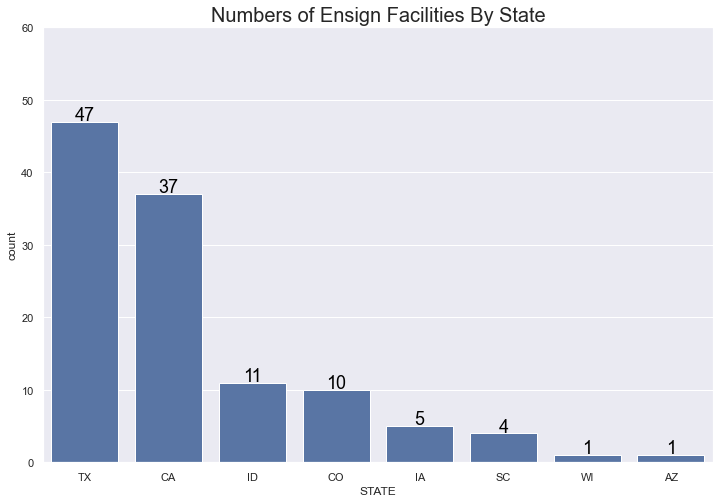

In [148]:
ensign_facility_df = ensign_nurse_df.groupby('PROVNUM').first()
sns.set(rc={"figure.figsize":(12, 8)})
ax = sns.countplot(x="STATE", data=ensign_facility_df, color='b',
                   order = ensign_facility_df['STATE'].value_counts().index)
ax.set_title('Numbers of Ensign Facilities By State', fontsize=20)
ax.set(ylim=(0, 60))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height() + 5.0), ha='center', va='top', color='black', size=18)

### A total of 116 Ensign nursing homes are included in the data. That's of 53% of all Ensign's providers.
### Ensign owns about 0.8% of the nursing homes in the US.
### The Ensign nursing home facilities are in eight different states: TX, CA, ID, CO, IA, SC, WI, and AZ
### Most of Ensign's nursing home facilities are in Texas (47), and California (37)

In [153]:
len(ensign_facility_df)/len(nursing_facilities_df) * 100

0.7879364216818366

In [158]:
len(ensign_prov_nums)

218

In [161]:
len(ensign_facility_df)

116

In [160]:
len(ensign_facility_df)/len(ensign_prov_nums)

0.5321100917431193

#### Columns with high zero values: 
       'Hrs_RNDON', 'Hrs_RNDON_emp', 'Hrs_RNDON_ctr', 'Hrs_RNadmin',  
       'Hrs_RNadmin_emp', 'Hrs_RNadmin_ctr', 'Hrs_RN_ctr', 'Hrs_LPNadmin',  
       'Hrs_LPNadmin_emp', 'Hrs_LPNadmin_ctr', 'Hrs_LPN_ctr', 'Hrs_CNA_ctr',  
       'Hrs_NAtrn', 'Hrs_NAtrn_emp', 'Hrs_NAtrn_ctr', 'Hrs_MedAide',  
       'Hrs_MedAide_emp', 'Hrs_MedAide_ctr'  

In [10]:
nurse_null_df = check_null_values(nursing_df)
nurse_null_df[nurse_null_df['percent_zero'] > 39.0].columns

Index(['columns', 'percent_null', 'percent_zero'], dtype='object')

In [57]:
all_nursing_df = add_features(nursing_df, q4_holidays, ensign_prov_nums)
all_nursing_df[features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,Hrs_NAtrn
count,1.350550e+06,1.350550e+06,1.350550e+06,1.350550e+06,1.350550e+06,1.350550e+06
mean,2.919040e+02,2.191674e+01,2.699872e+02,1.321208e+01,2.786919e+02,5.490775e+00
std,1.800604e+02,2.226532e+01,1.689143e+02,3.627630e+01,1.729659e+02,1.415226e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.750000e+02,5.710000e+00,1.607500e+02,0.000000e+00,1.663000e+02,0.000000e+00
50%,2.562500e+02,1.650000e+01,2.364000e+02,0.000000e+00,2.450000e+02,0.000000e+00
75%,3.622075e+02,3.200000e+01,3.352500e+02,8.000000e+00,3.477275e+02,0.000000e+00
max,4.316830e+03,4.290000e+02,3.937330e+03,1.137730e+03,4.316830e+03,2.772500e+02


In [85]:
def compare_data_distribution(df1, df2, metric):
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    df1.hist(metric, bins=np.arange(0, df1[metric].max() + 10, 10) , ax=axes[0])
    axes[0].set_title('USA')
    axes[0].set_xlabel(metric)
    df2.hist(metric, bins=np.arange(0, df2[metric].max() + 10, 10) , ax=axes[1])
    axes[1].set_title('Ensign')
    axes[1].set_xlabel(metric);

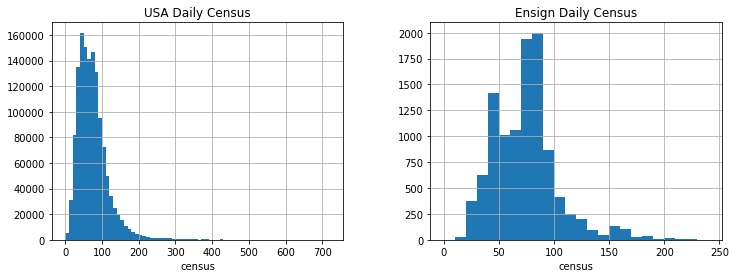

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
all_nursing_df.hist('MDScensus', bins=np.arange(0, all_nursing_df['MDScensus'].max() + 10, 10) , ax=axes[0])
axes[0].set_title('USA Daily Census')
axes[0].set_xlabel('census')
ensign_nurse_df.hist('MDScensus', bins=np.arange(0, ensign_nurse_df['MDScensus'].max() + 10, 10) , ax=axes[1])
axes[1].set_title('Ensign Daily Census')
axes[1].set_xlabel('census');

### Most facilities in the US have daily census less than 200.   
### All Ensign facilities have daily cencus < 250.   
### The variations could be related to the facility's size, but we don't have information about it.  

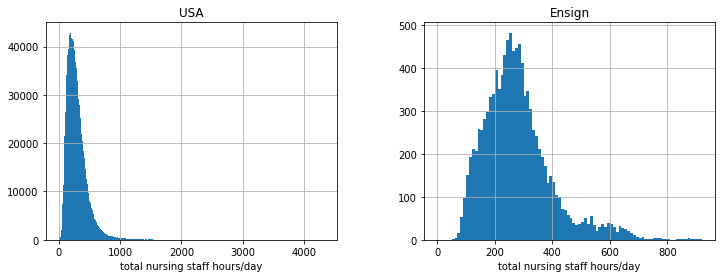

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
all_nursing_df.hist('total_hours', bins=np.arange(0, all_nursing_df['total_hours'].max() + 10, 10) , ax=axes[0])
axes[0].set_title('USA')
axes[0].set_xlabel('total nursing staff hours/day')
ensign_nurse_df.hist('total_hours', bins=np.arange(0, ensign_nurse_df['total_hours'].max() + 10, 10) , ax=axes[1])
axes[1].set_title('Ensign')
axes[1].set_xlabel('total nursing staff hours/day');

### Most US facilities in the US have total nursing staff hours less than 1000 hours/day
### Most Ensing facilities have total nursing staff hours less than 800 hours/day
### Again, the variations could be due to facility size and census

In [80]:
# ax = all_nursing_df.plot.hexbin(x='MDScensus', y='total_hours', gridsize=10, sharex=False, figsize=(5,4))

In [84]:
# drop outliers
nurse_staff_df = all_nursing_df[all_nursing_df['MDScensus'] < 250]
nurse_staff_df = nurse_staff_df[nurse_staff_df['total_hours'] < 1000]
len(nurse_staff_df)

1336434

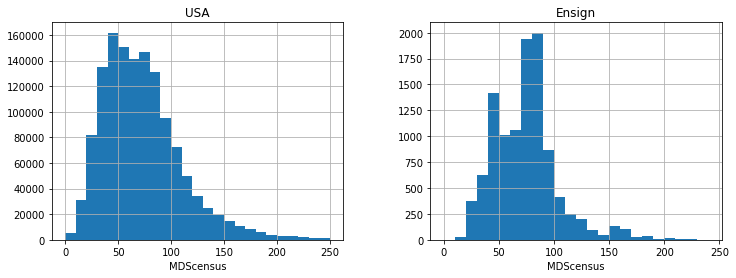

In [86]:
compare_data_distribution(nurse_staff_df, ensign_nurse_df, 'MDScensus')

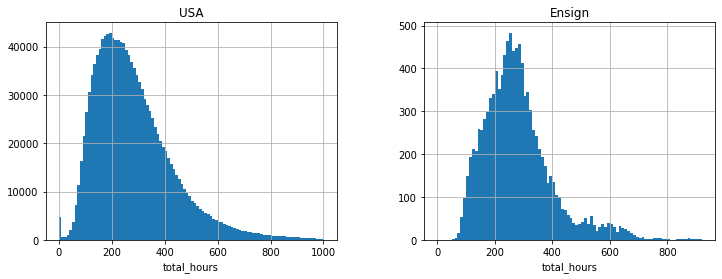

In [87]:
compare_data_distribution(nurse_staff_df, ensign_nurse_df, 'total_hours')

In [88]:
per_patient_nurse_df = staff_hours_per_person(nurse_staff_df, hour_features)
per_patient_nurse_df[features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,Hrs_NAtrn
count,1.336434e+06,1.336434e+06,1.336434e+06,1.336434e+06,1.336434e+06,1.336434e+06
mean,4.101027e+00,3.283848e-01,3.772693e+00,1.716177e-01,3.929413e+00,7.775167e-02
std,1.576994e+00,3.382902e-01,1.426760e+00,4.159716e-01,1.597343e+00,1.963288e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.340000e+00,7.000000e-02,3.090000e+00,0.000000e+00,3.160000e+00,0.000000e+00
50%,3.910000e+00,2.900000e-01,3.610000e+00,0.000000e+00,3.770000e+00,0.000000e+00
75%,4.610000e+00,4.900000e-01,4.230000e+00,1.300000e-01,4.470000e+00,0.000000e+00
max,2.446000e+02,4.000000e+01,2.218200e+02,2.000000e+01,2.446000e+02,4.800000e+00


In [89]:
ensign_per_patient_df = staff_hours_per_person(ensign_nurse_df, hour_features)
ensign_per_patient_df[features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,Hrs_NAtrn
count,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000
mean,3.870868,0.329137,3.541738,0.042712,3.828169,0.164784
std,0.903241,0.259682,0.809740,0.139305,0.900649,0.292434
min,1.470000,0.000000,1.460000,0.000000,1.380000,0.000000
25%,3.270000,0.100000,2.980000,0.000000,3.240000,0.000000
50%,3.770000,0.330000,3.450000,0.000000,3.730000,0.000000
75%,4.300000,0.480000,3.940000,0.000000,4.270000,0.220000
max,10.080000,1.960000,8.810000,1.620000,10.080000,2.150000


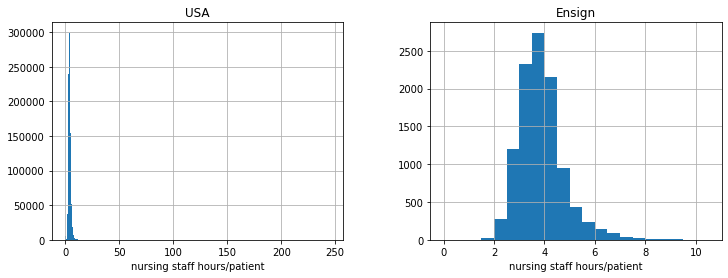

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
per_patient_nurse_df.hist('total_hours', bins=np.arange(0, per_patient_nurse_df['total_hours'].max() + 0.5, 0.5) , ax=axes[0])
axes[0].set_title('USA')
axes[0].set_xlabel('nursing staff hours/patient')
ensign_per_patient_df.hist('total_hours', bins=np.arange(0, ensign_per_patient_df['total_hours'].max() + 0.5, 0.5) , ax=axes[1])
axes[1].set_title('Ensign')
axes[1].set_xlabel('nursing staff hours/patient');

In [92]:
# remove outliers where hours per patient > 12
all_per_patient_df = per_patient_nurse_df[per_patient_nurse_df['total_hours'] <= 12]

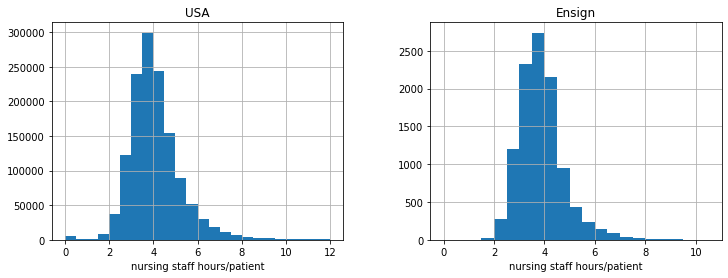

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
all_per_patient_df.hist('total_hours', bins=np.arange(0, all_per_patient_df['total_hours'].max() + 0.5, 0.5) , ax=axes[0])
axes[0].set_title('USA')
axes[0].set_xlabel('nursing staff hours/patient')
ensign_per_patient_df.hist('total_hours', bins=np.arange(0, ensign_per_patient_df['total_hours'].max() + 0.5, 0.5) , ax=axes[1])
axes[1].set_title('Ensign')
axes[1].set_xlabel('nursing staff hours/patient');

### After dropping the outliers, we can see that most facilities is the US have 2 - 6 nursing staff hours per patient per day, with the peak at aroud 3.8.
### The distribution is similar for the Ensign facilities.
### Next, we further explore the percentiles of nursing staff hours per patient:

In [162]:
# Percentiles of nursing staff hours per patient
all_per_patient_df['total_hours'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    2.58
0.25    3.34
0.50    3.91
0.75    4.61
0.95    6.20
Name: total_hours, dtype: float64

In [165]:
iqr_all = all_per_patient_df['total_hours'].quantile(0.75) - all_per_patient_df['total_hours'].quantile(0.25)
iqr_all

1.2700000000000005

In [163]:
# Percentiles of nursing staff hours per patient
ensign_per_patient_df['total_hours'].quantile([0.05, 0.25, 0.5, 0.75, 0.95])

0.05    2.66
0.25    3.27
0.50    3.77
0.75    4.30
0.95    5.54
Name: total_hours, dtype: float64

In [166]:
iqr_ensign = ensign_per_patient_df['total_hours'].quantile(0.75) - ensign_per_patient_df['total_hours'].quantile(0.25)
iqr_ensign

1.0299999999999998

### The Ensign's nursing staff hours IQR is less than the nation's nurse staffing hours IQR, indicating less variability of nursing staff hours per patient within the Ensign facilities.
### There are some days with very high and very low nursing staff hours per patient. Next, we will expolore more on those records within less than 5% percentile and more than 95% percentile.

In [132]:
# extract the records with > 95% nursing staff hours per patient
ensign_high_hour = ensign_per_patient_df[ensign_per_patient_df['total_hours'] > 6.20]
ensign_high_hour['PROVNUM'].nunique()

15

In [133]:
ensign_high_hour['PROVNUM'].value_counts().index

Int64Index([555871, 555258,  55632,  65404, 555326,  65417, 555545, 555739,
            555613, 135134, 555796, 135125,  55734,  55756, 135129],
           dtype='int64')

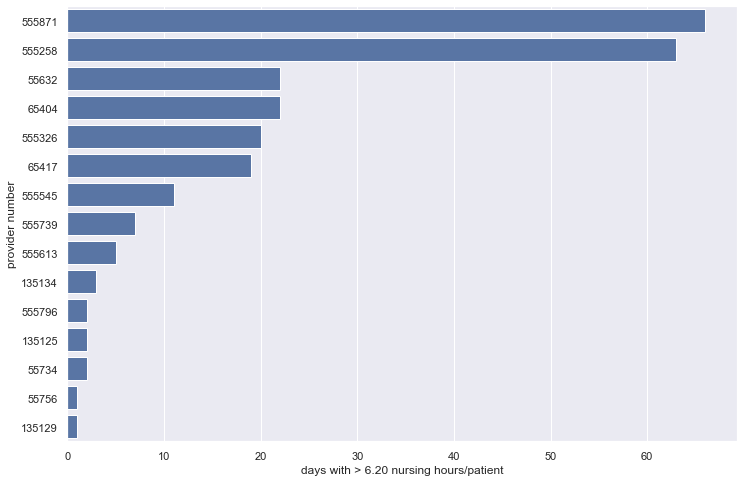

In [170]:
sns.set(rc={"figure.figsize":(12, 8)})
ax = sns.countplot(data=ensign_high_hour, y='PROVNUM', order=ensign_high_hour['PROVNUM'].value_counts().index, color='b');
ax.set(xlabel='days with > 6.20 nursing hours/patient', ylabel='provider number');

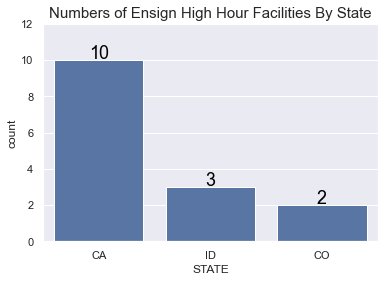

In [195]:
high_ensign_facility_df = ensign_high_hour.groupby('PROVNUM').first()
sns.set(rc={"figure.figsize":(6, 4)})
ax = sns.countplot(x="STATE", data=high_ensign_facility_df, color='b',
                   order = high_ensign_facility_df['STATE'].value_counts().index)
ax.set_title('Numbers of Ensign High Hour Facilities By State', fontsize=15)
ax.set(ylim=(0, 12))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height() + 2.0), ha='center', va='top', color='black', size=18)

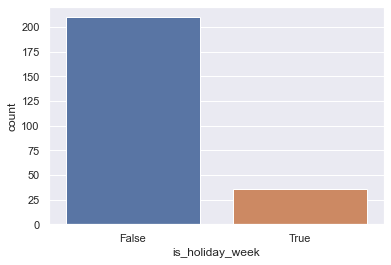

In [143]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_high_hour, x='is_holiday_week');

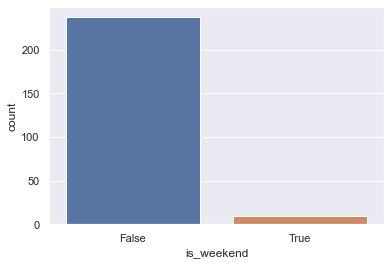

In [144]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_high_hour, x='is_weekend');

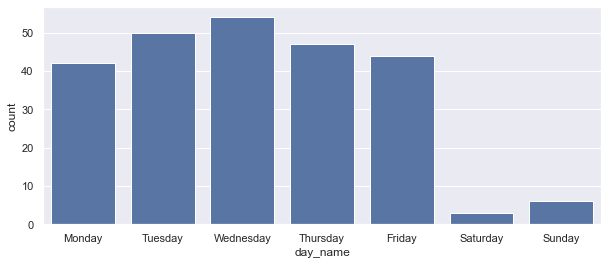

In [190]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.set(rc={"figure.figsize":(10, 4)})
sns.countplot(data=ensign_high_hour, x='day_name', order=order, color='b');

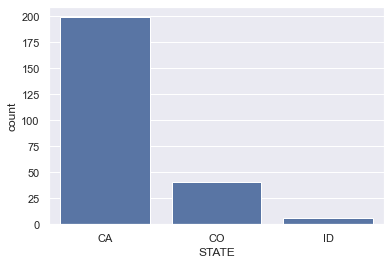

In [184]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_high_hour, x='STATE', order=ensign_high_hour['STATE'].value_counts().index, color='b');

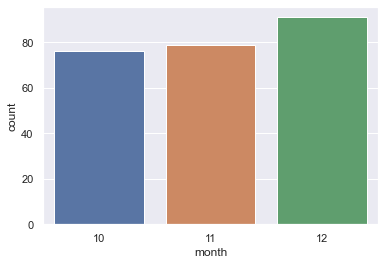

In [185]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_high_hour, x='month');

### There are 15 facilities with more than 6.20 nurse staff hours/patient in this quarter.
### 10 of the 15 facilities are in California, 3 in Idaho, and 2 in Colorado.
### California also has the most days with high with high nurse staff hours per patient
### High nurse staff hours occured mostly on weekdays, with only a few records on the weekends.
### High nurse staff hours doesn't seem to be related to months or holidays.

In [136]:
ensign_low_hour = ensign_per_patient_df[ensign_per_patient_df['total_hours'] < 2.58]
ensign_low_hour['PROVNUM'].nunique()

40

<AxesSubplot:xlabel='count', ylabel='PROVNUM'>

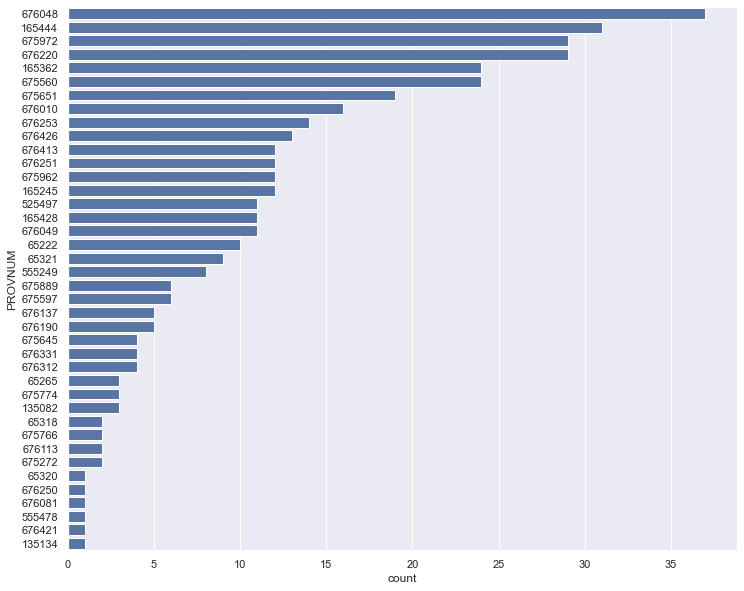

In [137]:
sns.set(rc={"figure.figsize":(12, 10)})
sns.countplot(data=ensign_low_hour, y='PROVNUM', order=ensign_low_hour['PROVNUM'].value_counts().index, color='b')

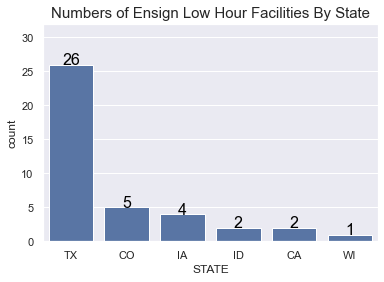

In [209]:
low_ensign_facility_df = ensign_low_hour.groupby('PROVNUM').first()
sns.set(rc={"figure.figsize":(6, 4)})
ax = sns.countplot(x="STATE", data=low_ensign_facility_df, color='b',
                   order = low_ensign_facility_df['STATE'].value_counts().index)
ax.set_title('Numbers of Ensign Low Hour Facilities By State', fontsize=15)
ax.set(ylim=(0, 32))
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height() + 4.3), ha='center', va='top', color='black', size=16)

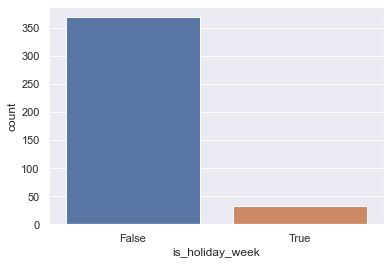

In [138]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_low_hour, x='is_holiday_week');

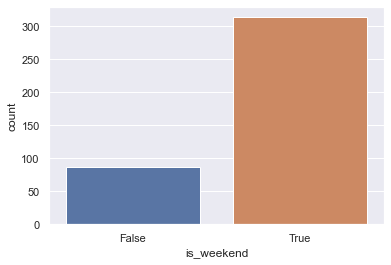

In [139]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_low_hour, x='is_weekend');

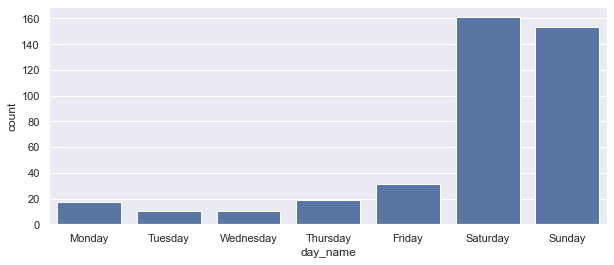

In [191]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.set(rc={"figure.figsize":(10, 4)})
sns.countplot(data=ensign_low_hour, x='day_name', order=order, color='b');

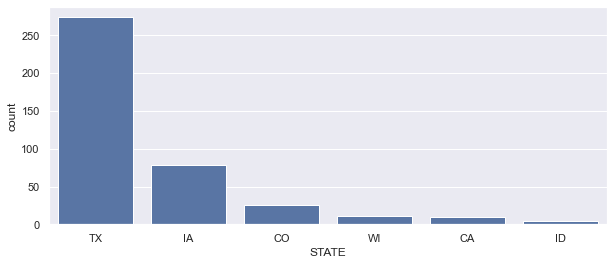

In [229]:
sns.set(rc={"figure.figsize":(10, 4)})
sns.countplot(data=ensign_low_hour, x='STATE', order=ensign_low_hour['STATE'].value_counts().index, color='b');

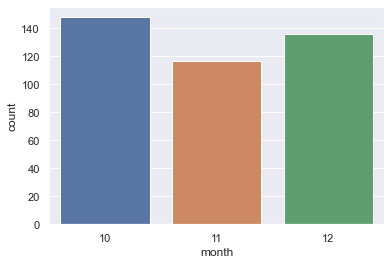

In [193]:
sns.set(rc={"figure.figsize":(6, 4)})
sns.countplot(data=ensign_low_hour, x='month');

### There are 40 Ensign facilities with less than 2.58 nurse staffing hours per patient in this quarter.
### More than half of the low hour facilities are in Texas (26), followed by IA, CO, WI, CA, and ID.
### Texas has the most records with low nurse staffing hours per patient.
### Most of the low nurse staff hours happened on the weekends.
### Low nurse staff hours doesn't seem to be related to months or holidays.

In [219]:
new_features = ['total_hours', 'total_admin_hours', 'total_non_admin', 'total_ctr_hours', 'total_non_ctr', 'MDScensus']
ensign_per_patient_df[new_features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,MDScensus
count,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000,10672.000000
mean,3.870868,0.329137,3.541738,0.042712,3.828169,73.641117
std,0.903241,0.259682,0.809740,0.139305,0.900649,29.409806
min,1.470000,0.000000,1.460000,0.000000,1.380000,13.000000
25%,3.270000,0.100000,2.980000,0.000000,3.240000,51.000000
50%,3.770000,0.330000,3.450000,0.000000,3.730000,74.000000
75%,4.300000,0.480000,3.940000,0.000000,4.270000,87.000000
max,10.080000,1.960000,8.810000,1.620000,10.080000,234.000000


Text(0.5, 1.0, 'All Ensign Facilities')

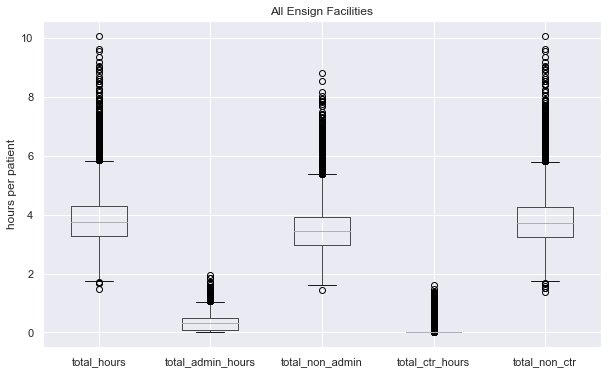

In [231]:
sns.set(rc={"figure.figsize":(10, 6)})
hour_columns = ['total_hours', 'total_admin_hours', 'total_non_admin', 'total_ctr_hours', 'total_non_ctr']
ax = ensign_per_patient_df.boxplot(column=hour_columns)
ax.set(ylabel='hours per patient')
ax.set_title('All Ensign Facilities');

In [214]:
ensign_high_hour[new_features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,MDScensus
count,246.000000,246.000000,246.000000,246.000000,246.00000,246.000000
mean,6.984024,0.751057,6.233252,0.086992,6.89687,41.402439
std,0.727244,0.377067,0.653705,0.253993,0.79338,21.096973
min,6.210000,0.000000,4.570000,0.000000,4.91000,13.000000
25%,6.452500,0.542500,5.812500,0.000000,6.41250,22.000000
50%,6.785000,0.620000,6.165000,0.000000,6.73000,41.000000
75%,7.235000,1.055000,6.520000,0.000000,7.17750,45.000000
max,10.080000,1.960000,8.810000,1.470000,10.08000,105.000000


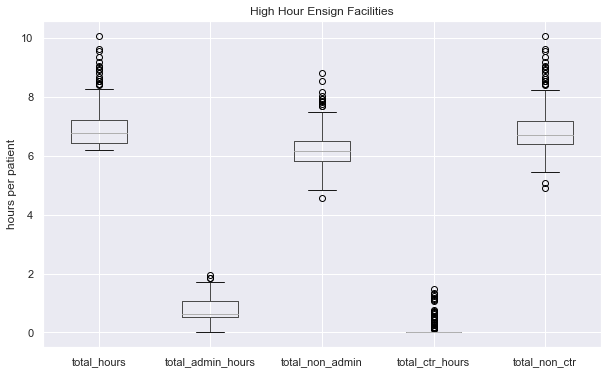

In [232]:
ax = ensign_high_hour.boxplot(column=hour_columns)
ax.set(ylabel='hours per patient')
ax.set_title('High Hour Ensign Facilities');

In [215]:
ensign_low_hour[new_features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,MDScensus
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,2.341272,0.080474,2.261022,0.029651,2.311696,71.875312
std,0.195611,0.125758,0.208672,0.085542,0.212417,29.495498
min,1.470000,0.000000,1.460000,0.000000,1.380000,25.000000
25%,2.250000,0.000000,2.140000,0.000000,2.190000,49.000000
50%,2.390000,0.000000,2.300000,0.000000,2.360000,74.000000
75%,2.490000,0.120000,2.420000,0.000000,2.480000,84.000000
max,2.570000,0.630000,2.570000,0.570000,2.570000,234.000000


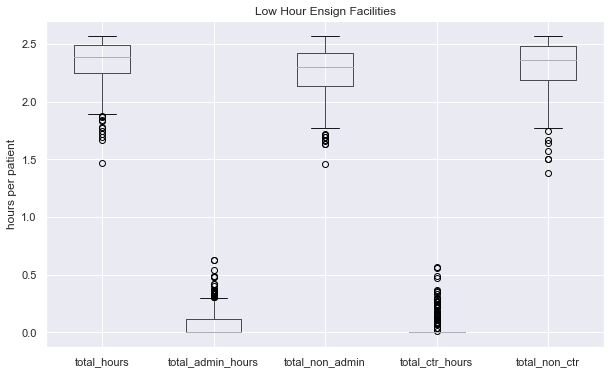

In [234]:
ax = ensign_low_hour.boxplot(column=hour_columns)
ax.set(ylabel='hours per patient')
ax.set_title('Low Hour Ensign Facilities');

In [12]:
clean_all_df = drop_by_hours_per_person(all_nursing_df)
clean_all_df[features].describe()

,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr,Hrs_NAtrn
count,1.340575e+06,1.340575e+06,1.340575e+06,1.340575e+06,1.340575e+06,1.340575e+06
mean,4.102563e+00,3.262764e-01,3.776337e+00,1.725934e-01,3.929973e+00,7.775059e-02
std,1.165389e+00,3.055112e-01,1.050318e+00,4.155742e-01,1.196992e+00,1.958824e-01
min,1.510000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.360000e+00,7.000000e-02,3.100000e+00,0.000000e+00,3.170000e+00,0.000000e+00
50%,3.920000e+00,2.900000e-01,3.610000e+00,0.000000e+00,3.770000e+00,0.000000e+00
75%,4.610000e+00,4.900000e-01,4.240000e+00,1.400000e-01,4.480000e+00,0.000000e+00
max,1.199000e+01,1.050000e+01,1.199000e+01,9.420000e+00,1.199000e+01,4.550000e+00


In [13]:
# ensign_nn_df = non_nursing_df[non_nursing_df["IsEnsign"] == True]
# ensign_nn_df.head()

In [14]:
ensign_nurse_df = clean_all_df[clean_all_df["IsEnsign"] == True]
ensign_nurse_df.head()

,PROVNUM,PROVNAME,CITY,STATE,COUNTY_NAME,COUNTY_FIPS,CY_Qtr,WorkDate,MDScensus,Hrs_RNDON,...,day,day_name,is_weekend,is_holiday_week,IsEnsign,total_hours,total_admin_hours,total_non_admin,total_ctr_hours,total_non_ctr
34224,35297,SURPRISE HEALTH AND REHABILITATION CENTER,SURPRISE,AZ,Maricopa,13,2020Q4,2020-10-01,78,0.10,...,1,Thursday,False,False,True,5.14,0.41,4.73,0.46,4.68
34225,35297,SURPRISE HEALTH AND REHABILITATION CENTER,SURPRISE,AZ,Maricopa,13,2020Q4,2020-10-02,72,0.11,...,2,Friday,False,False,True,5.70,0.44,5.26,0.65,5.06
34226,35297,SURPRISE HEALTH AND REHABILITATION CENTER,SURPRISE,AZ,Maricopa,13,2020Q4,2020-10-03,72,0.00,...,3,Saturday,True,False,True,4.54,0.00,4.54,0.81,3.73
34227,35297,SURPRISE HEALTH AND REHABILITATION CENTER,SURPRISE,AZ,Maricopa,13,2020Q4,2020-10-04,75,0.00,...,4,Sunday,True,False,True,4.06,0.00,4.06,0.57,3.49
34228,35297,SURPRISE HEALTH AND REHABILITATION CENTER,SURPRISE,AZ,Maricopa,13,2020Q4,2020-10-05,73,0.11,...,5,Monday,False,False,True,5.00,0.44,4.56,0.22,4.78


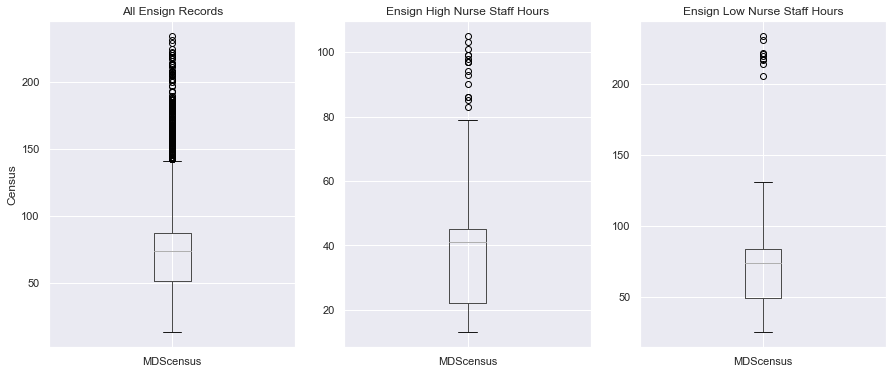

In [248]:
fig, axes = plt.subplots(1, 3, figsize=(15,6))
ensign_per_patient_df.boxplot(column='MDScensus', ax=axes[0])
ensign_high_hour.boxplot(column='MDScensus', ax=axes[1])
ensign_low_hour.boxplot(column='MDScensus', ax=axes[2])
axes[0].set_title('All Ensign Records')
axes[1].set_title('Ensign High Nurse Staff Hours')
axes[2].set_title('Ensign Low Nurse Staff Hours')
axes[0].set_ylabel('Census');

In [17]:
exist_pv = ensign_nurse_df["PROVNUM"].unique().astype('int32').squeeze().tolist()
non_exist_pv = []
for num in prov_nums:
    if num not in exist_pv:
        non_exist_pv.append(num)

In [18]:
len(non_exist_pv) + len(exist_pv) == len(prov_nums)

True

In [19]:
# ensign_nurse_df.to_csv(r'C:\Users\hua13\Google Drive\Ensign\ensign_nurse_df.csv', index=False, header=True)
# ensign_nn_df.to_csv(r'C:\Users\hua13\Google Drive\Ensign\ensign_nn_df.csv', index=False, header=True)

# clean_all_df.to_csv(r'C:\Users\hua13\Google Drive\Ensign\all_nurse_df.csv', index=False, header=True)
# non_nursing_df.to_csv(r'C:\Users\hua13\Google Drive\Ensign\all_nn_df.csv', index=False, header=True)